<a href="https://colab.research.google.com/github/doongjinn/pytorch_practice/blob/main/pytorch_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data loader

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15412781.40it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 225231.08it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4253247.92it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18662296.45it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



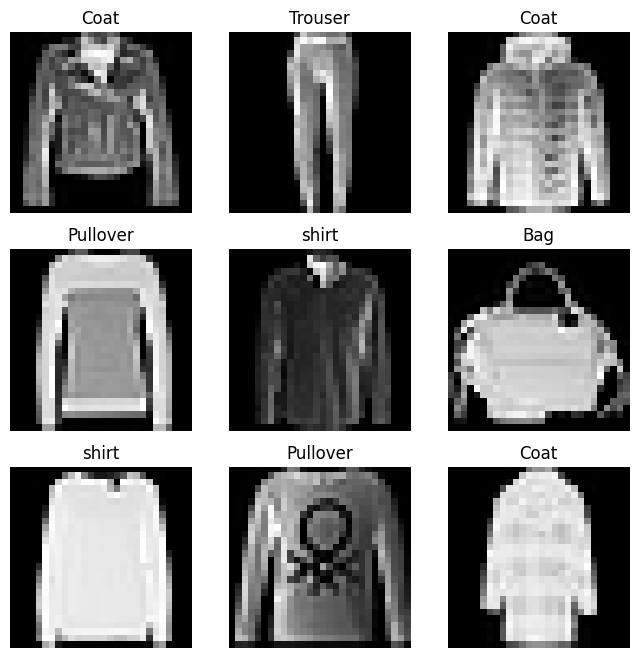

In [ ]:
labels_map = {
    0:"t-shirt",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle Boot",
}
figure = plt.figure(figsize=(8,8))
cols,rows = 3,3
for i in range(1,cols * rows +1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img,label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
import numpy as np

def softmax(a):
  exp_a = np.exp(a)
  sum_exp_a = np.sum(exp_a)
  y = exp_a/sum_exp_a
  return y
def cross_entropy_error(y, t):
  delta = 1e-7
  return -np.sum(t *np.log(y+delta))

t = [0,0,1,0,0]
y = [0.1,0.2,0.3,0.2,0.2]
y = softmax(y)
ce1 = cross_entropy_error(np.array(y), np.array(t))
print(ce1)

t = [0,1,0,0,0]
y = [0.5,0.2,0.1,0.1,0.1]
y = softmax(y)
ce2 = cross_entropy_error(np.array(y), np.array(t))
print(ce2)

print((ce1 + ce2)/2)

1.5114371256657235
1.622229450144605
1.5668332879051643


#fashion mnist

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform=ToTensor()
)
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in train_dataloader:
      print(f"Shape of X [N, C, H, W]: {X.shape}")
      print(f"Shape of y: {y.shape} {y.dtype}")
      break
for X, y in test_dataloader:
      print(f"Shape of X [N, C, H, W]: {X.shape}")
      print(f"Shape of y: {y.shape} {y.dtype}")
      break

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )
  def forward(self,x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits
model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  for batch,(X,y) in enumerate(dataloader):
    X,y = X.to(device),y.to(device)
    pred = model(X)
    loss = loss_fn(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 ==0:
      loss, current = loss.item(),batch *len(X)
      print(f"loss:{loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)

  model.eval()
  test_loss, correct = 0,0

  with torch.no_grad():
    for X,y in dataloader:
      X,y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n")

epochs = 5
for t in range(epochs):
  print(f"Epochs{t+1}\n---------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epochs1
---------------------------------
loss:2.296197 [    0/60000]
loss:2.291018 [ 6400/60000]
loss:2.266498 [12800/60000]
loss:2.262312 [19200/60000]
loss:2.244138 [25600/60000]
loss:2.206467 [32000/60000]
loss:2.217498 [38400/60000]
loss:2.172562 [44800/60000]
loss:2.177181 [51200/60000]
loss:2.140262 [57600/60000]
Test Error: 
 Accuracy: 44.9%, Avg loss:2.140139 

Epochs2
---------------------------------
loss:2.156699 [    0/60000]
loss:2.149240 [ 6400/60000]
loss: